# Question 1: Graph Classification

In this question we will be exploring graph classification on the dataset provided.

Overall, we will explore ways to implement graph level classification using GCNs; explore the given dataset and see how we can improve the GCN & training process overall to get a higher score on the dataset.

### HELPER FUNCTION & IMPORTS:

In [495]:
#Import Statements
import json
import torch
import os
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import networkx as nx
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [496]:
TRAIN_FILE_NAME = "q1_graph_classification_main_train.json"
EVAL_FILE_NAME = "q1_graph_classification_main_eval.json"

TRAIN_DATA_PATH = os.path.join("data",TRAIN_FILE_NAME)
EVAL_DATA_PATH = os.path.join("data",EVAL_FILE_NAME)

In [497]:
# Training function
def train_epoch(model, dataset, optimizer, criterion, return_embeddings=False, **kwargs):
    model.train()
    total_loss = 0
    all_embeddings_H1 = []
    all_labels_H1 = []

    for X, A, label in dataset:
        optimizer.zero_grad()

        # Forward pass with optional embeddings
        if return_embeddings:
            output, H1, _ = model(A, X, return_embeddings=True, **kwargs)
            all_embeddings_H1.append(H1.detach().cpu().numpy())  # Store H1 embeddings
        else:
            output = model(A, X, **kwargs)

        # Prepare label for BCELoss
        adjusted_label = 1 if label == 1 else 0
        label_tensor = torch.tensor([float(adjusted_label)], dtype=torch.float)
        all_labels_H1.append(label_tensor.detach().cpu().numpy())

        # Flatten the output to match the label tensor shape
        output_flat = output.view(-1)

        # Compute loss
        loss = criterion(output_flat, label_tensor)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(dataset)

    if return_embeddings:
        return average_loss, (all_embeddings_H1,all_labels_H1)
    else:
        return average_loss


# Testing function
def test(model, dataset, **kwargs):
    model.eval()
    true_labels = []
    predicted_labels = []
    correct = 0

    with torch.no_grad():
        for X, A, label in dataset:
            output = model(A, X, **kwargs)

            # Convert sigmoid output to binary prediction
            predicted = (output >= 0.5).int().item()

            # Adjust labels to match binary predictions (0 and 1)
            adjusted_label = 1 if label == 1 else 0

            true_labels.append(adjusted_label)
            predicted_labels.append(predicted)
            correct += (predicted == adjusted_label)

    accuracy = correct / len(dataset)
    return true_labels, predicted_labels, accuracy


In [498]:
# Functions to load the data
def create_Adj_matrix(N, edge_index):
    """Creates the adjacency matrix"""
    A = torch.zeros((N, N), dtype=torch.float)
    for idx, jdx in edge_index:
        A[idx, jdx] = 1
        A[jdx, idx] = 1
    return A

def read_json_data(file_path, has_label=True):
    with open(file_path, 'r') as f:
        data = json.load(f)
        
    graph_data = []
    for item in data:
        X = torch.tensor(item['features'], dtype=torch.float)
        N = len(X)
        A = create_Adj_matrix(N, item['edge_index'])
        if has_label:
            y = torch.tensor(item['label'], dtype=torch.long)
        else:
            y = None
        
        graph_data.append((X,A,y))
    
    return graph_data


## Question 1.1 - Graph-Level Aggregation and Training

### Graph Convolutional Network (GCN)

We are going to use a 2-layer GCN for the **binary node classification** task on the heterogeneous graph. Below, you can see the mathematical representation to generate predictions from GCN.

The feature update rule for the next layer $ H_{k+1} $ in a graph convolutional network is given by the equation

$$
$$

where  $\tilde{D}$ is the degree matrix with added self-loops, $\tilde{A}$ is the adjacency matrix with self-loops, $H_k$ are the features from the previous layer, $ \Omega_k $ is the weight matrix at layer $ k $, $\Beta_k$ is the bias vector at layer $k$, and $\sigma $ denotes the activation function.


$\tilde{D}^{-1/2} \tilde{A} \tilde{D}^{-1/2}$ is the normalized adjacency matrix with self-loops. Below, you need to implement this normalization function.

In [499]:
# Helper function to normalise the A matrix
def symmetric_normalize(A_tilde):
    """
    Performs symmetric normalization of A_tilde (Adj. matrix with self loops):
      A_norm = D^{-1/2} * A_tilde * D^{-1/2}
    Where D_{ii} = sum of row i in A_tilde.

    A_tilde (N, N): Adj. matrix with self loops
    Returns:
      A_norm : (N, N)
    """

    eps = 1e-5
    d = A_tilde.sum(dim=1) + eps
    D_inv = torch.diag(torch.pow(d, -0.5))
    return D_inv @ A_tilde @ D_inv


### Q1.1.a - Graph-Level GCN

Implement three graph-level aggregation methods: sum, mean, and max. A GCN implemen-
tation is provided, and your task is to adapt it into a graph-level GCN by integrating different
aggregation functions.

In [515]:
# SOLUTION Q1.1.a

# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################
class MyGCNLayer(nn.Module):
    """
    A single layer of a Graph Convolutional Network (GCN).
    """
    def __init__(self, input_dim, output_dim, use_nonlinearity=True):
        super(MyGCNLayer, self).__init__()
        self.use_nonlinearity = use_nonlinearity
        self.Omega = nn.Parameter(torch.randn(input_dim, output_dim) * torch.sqrt(torch.tensor(2.0) / (input_dim + output_dim)))
        self.beta = nn.Parameter(torch.zeros(output_dim))

    def forward(self, H_k, A_normalized):
        agg = torch.matmul(A_normalized, H_k) # local agg
        H_k_next = torch.matmul(agg, self.Omega) + self.beta
        return F.relu(H_k_next) if self.use_nonlinearity else H_k_next

class MyGraphNeuralNetwork(nn.Module):
    """
    A simple Graph Neural Network model using two layers of Graph Convolutional Network (GCN)
    for binary classification. The sigmoid activation is applied in the output layer only if
    use_nonlinearity is set to True.
    """
    def __init__(self, input_dim, hidden_dim):
        super(MyGraphNeuralNetwork, self).__init__()

        # Define GCN layers
        self.gcn1 = MyGCNLayer(input_dim, hidden_dim, True)
        self.gcn2 = MyGCNLayer(hidden_dim, 1, False)
        self.output_dim = 1 # output dim is always 1 for this first appraoch

    def forward(self, A, X, graph_aggregation_method='max', **kwargs):
        # Pass through GCN layers
        # Normalizing layers before passing through GCN
        A_tilde = A + torch.eye(A.shape[0])  # Add self-loops
        A_norm = symmetric_normalize(A_tilde)
        
        H1 = self.gcn1(X, A_norm)
        H2 = self.gcn2(H1, A_norm)  # Output shape: (num_nodes, 1)

        # Graph-level aggregation, testing different aggregation methods
        if graph_aggregation_method == "sum":
            graph_embedding = torch.sum(H2, dim=0)
        elif graph_aggregation_method == "mean":
            graph_embedding = torch.mean(H2, dim=0)
        elif graph_aggregation_method == "max":
            graph_embedding, _ = torch.max(H2, dim=0)
        
        graph_output = torch.sigmoid(graph_embedding)

        # Handle NaN values
        if torch.isnan(graph_output).any():
            graph_output = torch.where(torch.isnan(graph_output), torch.zeros_like(graph_output), graph_output)

        if kwargs.get("return_embeddings", None):
            return graph_output, H1, H2
        else:
            return graph_output
        
# ####################################################
# END OF MODIFICATION
# ####################################################

### Test your solution runs for all three aggregation methods.

Note - the input dataset features have dimensionionality 10.

### A full end-2-end Training script (make sure the below runs)

You only need to modify the aggregation parameter in this case.

In [501]:
# Preparing the Basics:
# Load data
train_data = read_json_data(TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
eval_data = read_json_data(EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# Initialising the model
input_dim = 10
hidden_dim = 32
model = MyGraphNeuralNetwork(input_dim, hidden_dim)
print(model)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

MyGraphNeuralNetwork(
  (gcn1): MyGCNLayer()
  (gcn2): MyGCNLayer()
)


In [502]:
# Training the model
random.shuffle(train_data)

# Training
num_epochs = 50

# Testing across all aggregation methods
agg_methods = ["sum", "mean", "max"]
all_losses = {agg: [] for agg in agg_methods}

# Train without returning embeddings for other epochs
#note train_epoch accepts the additional param graph_aggregation_method and passes it (via kwargs) to the model.forward method.

# ####################################################
# MODIFY THE CODE BELOW 
#  (note only aggregation param - and make sure to run all of them)
# ####################################################    
for agg_method in agg_methods:
    print(f" Training with aggregator = {agg_method}")
    loss_values = []
    for epoch in range(num_epochs):
        loss = train_epoch(model, train_data, optimizer, criterion, graph_aggregation_method=agg_method)
        print(f"Epoch {epoch+1}, Loss: {loss: .4f}")
        loss_values.append(loss)


    # ####################################################
    # END OF MODIFICATION
    # ####################################################   
    all_losses[agg_method] = loss_values

 Training with aggregator = sum
Epoch 1, Loss:  0.3901
Epoch 2, Loss:  0.3585
Epoch 3, Loss:  0.3497
Epoch 4, Loss:  0.3441
Epoch 5, Loss:  0.3399
Epoch 6, Loss:  0.3366
Epoch 7, Loss:  0.3336
Epoch 8, Loss:  0.3309
Epoch 9, Loss:  0.3282
Epoch 10, Loss:  0.3257
Epoch 11, Loss:  0.3232
Epoch 12, Loss:  0.3206
Epoch 13, Loss:  0.3180
Epoch 14, Loss:  0.3157
Epoch 15, Loss:  0.3132
Epoch 16, Loss:  0.3108
Epoch 17, Loss:  0.3085
Epoch 18, Loss:  0.3061
Epoch 19, Loss:  0.3038
Epoch 20, Loss:  0.3013
Epoch 21, Loss:  0.2991
Epoch 22, Loss:  0.2968
Epoch 23, Loss:  0.2945
Epoch 24, Loss:  0.2923
Epoch 25, Loss:  0.2901
Epoch 26, Loss:  0.2879
Epoch 27, Loss:  0.2857
Epoch 28, Loss:  0.2836
Epoch 29, Loss:  0.2819
Epoch 30, Loss:  0.2798
Epoch 31, Loss:  0.2780
Epoch 32, Loss:  0.2760
Epoch 33, Loss:  0.2742
Epoch 34, Loss:  0.2722
Epoch 35, Loss:  0.2706
Epoch 36, Loss:  0.2688
Epoch 37, Loss:  0.2670
Epoch 38, Loss:  0.2652
Epoch 39, Loss:  0.2634
Epoch 40, Loss:  0.2618
Epoch 41, Loss:  

In [503]:
# Evaluate the model on the test set
true_labels, predicted_labels, accuracy = test(model, eval_data)

# Debug: Print true and predicted labels
print("True labels:", true_labels)
print("Predicted labels:", predicted_labels)

# Calculate precision, recall (sensitivity), and F1-score
precision = precision_score(true_labels, predicted_labels, average='macro', zero_division=0)
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

# Print out the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

True labels: [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Predicted labels: [0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0]
Accuracy: 0.5500
Precision: 0.5514
Recall: 0.5500
F1-score: 0.5469


### Q1.1.b. Graph-Level Training

Make modifications to the training script to:
1. Train the model and record the training loss and evaluation accuracy for each epoch.
2. Plot the test f1 for all three aggregation methods.

Use the provided functions:

• train model

• plot training and evaluation

In [504]:
# Helper function for plotting:
def plot_training_and_validation(training_metrics, validation_metrics, aggregation="mean", graph1_label="Training", graph2_label="Validation", x_label="Epoch",title=None, metric="Accuracy"):
    """
    Plots the validation accuracy and training loss over epochs.
    Args:
        validation_losses: List of validation accuracies (or losses)
        training_losses: List of training accuracies (or losses)
        aggregation: Aggregation method used (default: "mean")
    """
    plt.figure(figsize=(10, 6))
    
    # Create figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()
    
    graph1_label = f"{graph1_label} {metric}"
    graph2_label = f"{graph2_label} {metric}"
    
    # Plot training loss on the first y-axis
    epochs = range(1, len(training_metrics) + 1)
    line1 = ax1.plot(epochs, training_metrics, 'r-', label=f'{graph1_label}')
    ax1.set_xlabel(f"{x_label}")
    ax1.set_ylabel(f'{graph1_label}', color='r')
    ax1.tick_params(axis='y', labelcolor='r')
    
    # Plot validation accuracy on the second y-axis
    line2 = ax2.plot(epochs, validation_metrics, 'b-', label=f'{graph2_label}')
    ax2.set_ylabel(f'{graph2_label}', color='b')
    ax2.tick_params(axis='y', labelcolor='b')
    
    # Add title and grid
    if not title:
        title = f'Training {metric} and Validation {metric} Over Time\nAggregation: {aggregation}'
    plt.title(title)

    ax1.grid(True)
    
    # Add legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='lower right')
    
    plt.tight_layout()
    plt.show()

In [505]:
# SOLUTION Q1.1.b
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  

def train_model(model, optimizer, criterion, train_dataset, validation_dataset, epochs, graph_aggregation_method, verbose):
    """Trains the model and records loss and validation accuracy
    Should return, train_losses, train_accuracy, validation_accuracy
    """
    train_losses = []
    train_accs = []
    train_f1s = []
    val_accs = []
    val_f1s = []
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0
        true_train_labels = []
        predicted_train_labels = []
        
        for train_data in train_dataset:
            
            # forward pass 
            (X, A, label) = train_data
            true_train_labels.append(label)
            
            label_tensor = torch.tensor([label], dtype=torch.float)
            output = model(A, X, graph_aggregation_method=graph_aggregation_method)

            # If output is 1D, unsqueeze it to add a batch dimension.
            if output.dim() == 1:
                output = output.unsqueeze(0)

            # Determine the type of loss by checking the output's shape:
            #   - BCE: output shape [batch, 1] -> create target as float.
            #   - CrossEntropy: output shape [batch, 2] -> create target as long.
            if output.shape[1] == 1:
                # BCE case: create target tensor and unsqueeze it to [1,1]
                target = torch.tensor([label], dtype=torch.float, device=output.device).unsqueeze(1)
            elif output.shape[1] == 2:
                # CrossEntropy case: create target tensor as long
                target = torch.tensor([label], dtype=torch.long, device=output.device)
            else:
                raise ValueError(f"Unexpected output shape: {output.shape}")

            loss = criterion(output, target)
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # calculate loss
            total_loss += loss.item()

            # Compute predictions
            if output.shape[1] == 1:
                # BCE: threshold the probability at 0.5.
                pred = (output >= 0.5).int().item()
            elif output.shape[1] == 2:
                # CrossEntropy: take argmax along dim 1.
                pred = torch.argmax(output, dim=1).item()
            predicted_train_labels.append(pred)
            if pred == label:
                correct += 1
            total += 1
        
        avg_train_loss = total_loss / len(train_dataset)
        train_acc = correct / total
        train_f1 = f1_score(true_train_labels, predicted_train_labels, average='macro')
        
        # validation
        model.eval()
        correct_val = 0
        total_val = 0
        true_eval_labels = []
        predicted_eval_labels = []
        with torch.no_grad():
            for val_data in validation_dataset:
                # forward pass
                (X_val, A_val, label_val) = val_data
                true_eval_labels.append(label_val)
                output_val = model(A_val, X_val, graph_aggregation_method=graph_aggregation_method)

                # Ensure output_val is at least 2D.
                if output_val.dim() == 0:
                    output_val = output_val.unsqueeze(0).unsqueeze(0)
                elif output_val.dim() == 1:
                    output_val = output_val.unsqueeze(0)

                if output_val.shape[1] == 1:
                    pred_val = (output_val >= 0.5).int().item()
                elif output_val.shape[1] == 2:
                    pred_val = torch.argmax(output_val, dim=1).item()
                predicted_eval_labels.append(pred_val)
                if pred_val == label_val:
                    correct_val += 1
                total_val += 1
            
        val_acc = correct_val / total_val
        f1 = f1_score(true_eval_labels, predicted_eval_labels, average='macro')
        val_f1s.append(f1)
        train_f1s.append(train_f1)
        
        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        


        # INCLUDE THiS STATEMENT IN YOUR CODE
        if verbose:
            print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss}, Train Accuracy: {train_acc}, Validation Accuracy: {val_acc:.4f}")

    return train_losses, train_accs, val_accs, train_f1s, val_f1s

# ####################################################
# END OF MODIFICATION
# ####################################################  

Epoch 1, Training Loss: 0.4151835905857187, Train Accuracy: 0.7537878787878788, Validation Accuracy: 0.5000
Epoch 2, Training Loss: 0.38587662318340415, Train Accuracy: 0.75, Validation Accuracy: 0.5000
Epoch 3, Training Loss: 0.3742158123517804, Train Accuracy: 0.75, Validation Accuracy: 0.5000
Epoch 4, Training Loss: 0.3657134164152949, Train Accuracy: 0.75, Validation Accuracy: 0.5000
Epoch 5, Training Loss: 0.358367699558254, Train Accuracy: 0.75, Validation Accuracy: 0.5000
Epoch 6, Training Loss: 0.3524920197104979, Train Accuracy: 0.75, Validation Accuracy: 0.5000
Epoch 7, Training Loss: 0.34795064256865194, Train Accuracy: 0.7537878787878788, Validation Accuracy: 0.5000
Epoch 8, Training Loss: 0.34454680388003134, Train Accuracy: 0.7537878787878788, Validation Accuracy: 0.5000
Epoch 9, Training Loss: 0.341496530546327, Train Accuracy: 0.7537878787878788, Validation Accuracy: 0.5000
Epoch 10, Training Loss: 0.3388609101812383, Train Accuracy: 0.7575757575757576, Validation Accur

<Figure size 1000x600 with 0 Axes>

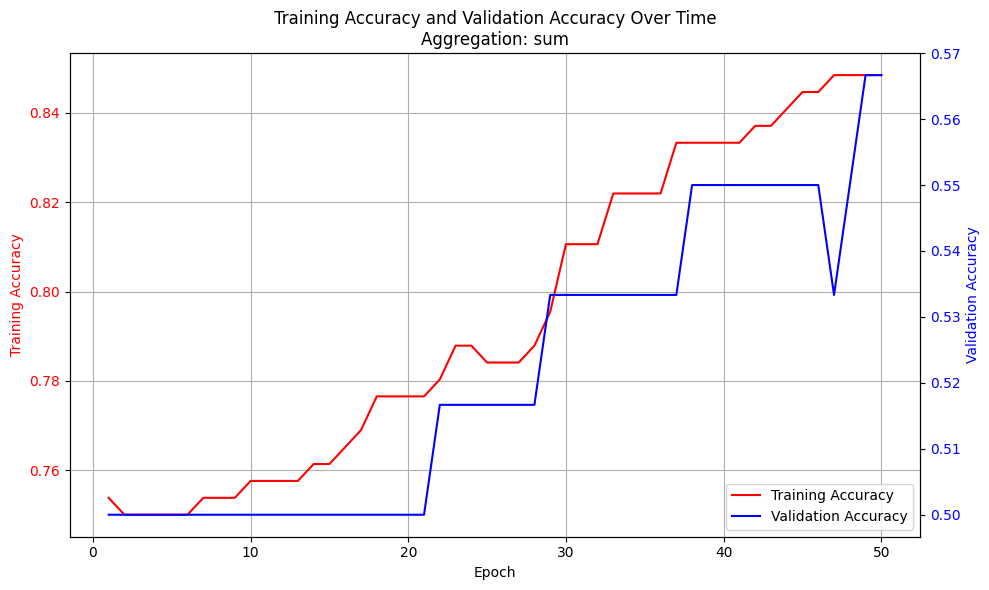

Epoch 1, Training Loss: 0.6358866482747324, Train Accuracy: 0.7386363636363636, Validation Accuracy: 0.5000
Epoch 2, Training Loss: 0.5734700466873068, Train Accuracy: 0.75, Validation Accuracy: 0.5000
Epoch 3, Training Loss: 0.5591470726737471, Train Accuracy: 0.75, Validation Accuracy: 0.5000
Epoch 4, Training Loss: 0.5554956421256065, Train Accuracy: 0.75, Validation Accuracy: 0.5000
Epoch 5, Training Loss: 0.5534175737676296, Train Accuracy: 0.75, Validation Accuracy: 0.5000
Epoch 6, Training Loss: 0.5516228632380565, Train Accuracy: 0.75, Validation Accuracy: 0.5000
Epoch 7, Training Loss: 0.5498926486594208, Train Accuracy: 0.75, Validation Accuracy: 0.5000
Epoch 8, Training Loss: 0.5481752379599846, Train Accuracy: 0.75, Validation Accuracy: 0.5000
Epoch 9, Training Loss: 0.5464118484294775, Train Accuracy: 0.75, Validation Accuracy: 0.5000
Epoch 10, Training Loss: 0.5445525518646745, Train Accuracy: 0.75, Validation Accuracy: 0.5000
Epoch 11, Training Loss: 0.5425855398855426, 

<Figure size 1000x600 with 0 Axes>

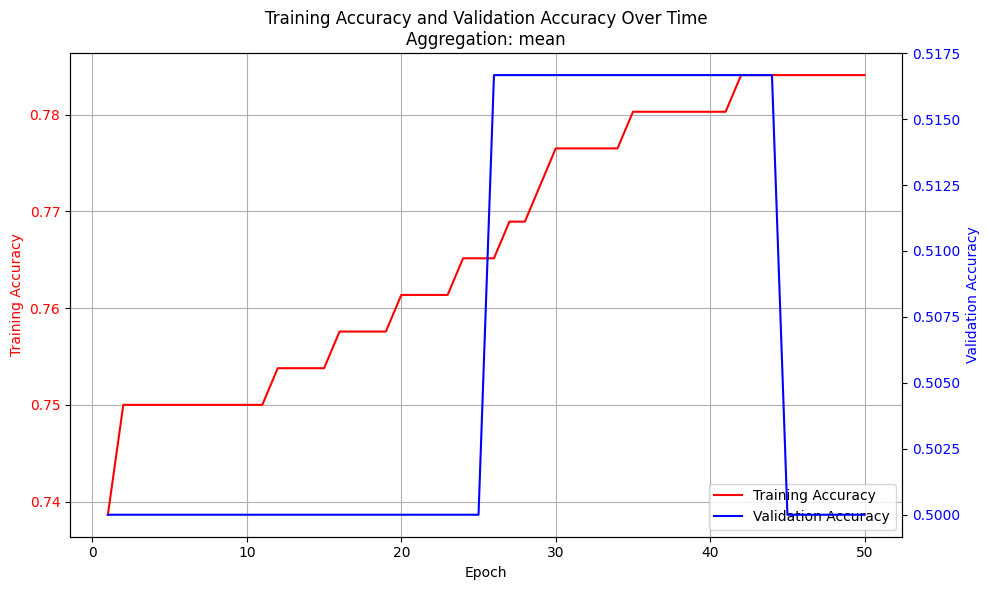

Epoch 1, Training Loss: 0.6282742491951494, Train Accuracy: 0.7462121212121212, Validation Accuracy: 0.5000
Epoch 2, Training Loss: 0.5612029287625443, Train Accuracy: 0.75, Validation Accuracy: 0.5000
Epoch 3, Training Loss: 0.542366444443663, Train Accuracy: 0.75, Validation Accuracy: 0.5000
Epoch 4, Training Loss: 0.5334030194490245, Train Accuracy: 0.75, Validation Accuracy: 0.5000
Epoch 5, Training Loss: 0.5245459959701155, Train Accuracy: 0.75, Validation Accuracy: 0.5000
Epoch 6, Training Loss: 0.5154066091459809, Train Accuracy: 0.7537878787878788, Validation Accuracy: 0.5000
Epoch 7, Training Loss: 0.5064608650282025, Train Accuracy: 0.7575757575757576, Validation Accuracy: 0.5167
Epoch 8, Training Loss: 0.4977454198242137, Train Accuracy: 0.7613636363636364, Validation Accuracy: 0.5333
Epoch 9, Training Loss: 0.4898291593981963, Train Accuracy: 0.7651515151515151, Validation Accuracy: 0.5667
Epoch 10, Training Loss: 0.4821488813243129, Train Accuracy: 0.7689393939393939, Vali

<Figure size 1000x600 with 0 Axes>

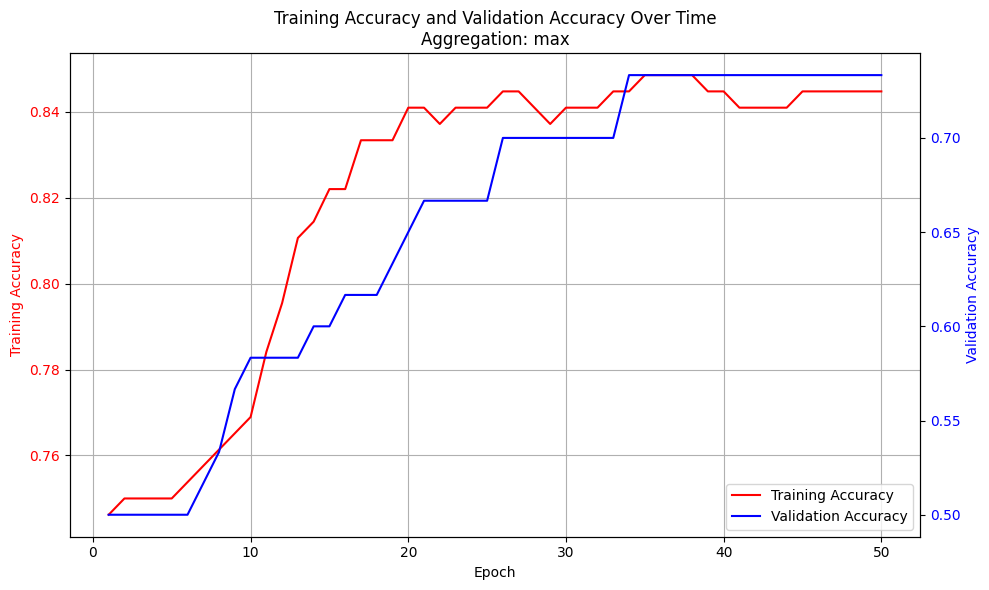

In [506]:
# Run all three aggregation functions here.
# Load data
train_data = read_json_data(TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
eval_data = read_json_data(EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

criterion = nn.BCELoss()

# Initialising the model
input_dim = 10
hidden_dim = 16

all_train_losses = {}
all_eval_accs = {}

# Visualising
for agg_method in ["sum", "mean", "max"]:
    # TRAIN
    num_epochs = 50
    model = MyGraphNeuralNetwork(input_dim, hidden_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    train_losses, train_acc, eval_acc, _, _ = train_model(
        model, optimizer, criterion,
        train_dataset=train_data,
        validation_dataset=eval_data,
        epochs=num_epochs,
        graph_aggregation_method=agg_method,
        verbose=True
    )
    
    all_train_losses[agg_method] = train_losses
    all_eval_accs[agg_method] = eval_acc
    
    plot_training_and_validation(train_acc, eval_acc, aggregation=agg_method)

### Q1.1.c - Training vs. Evaluation F1

Additionally, compare training F1 scores vs. evaluation F1 scores. What differences do you
observe? Which aggregation function performs best and why (sum, mean, or max)?

Final Train F1: 0.7000
Final Val F1: 0.4841


<Figure size 1000x600 with 0 Axes>

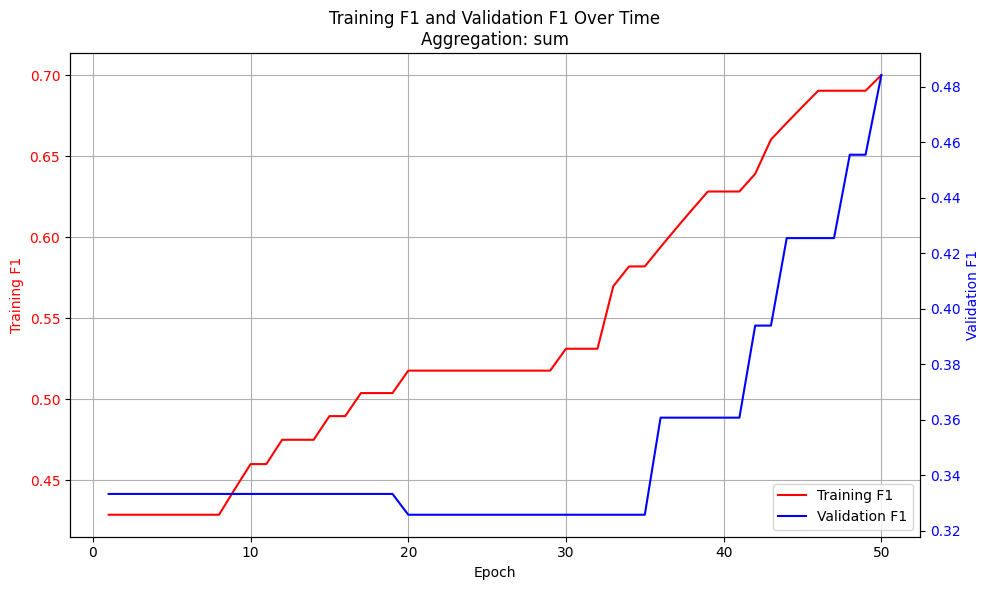

Final Train F1: 0.5571
Final Val F1: 0.4034


<Figure size 1000x600 with 0 Axes>

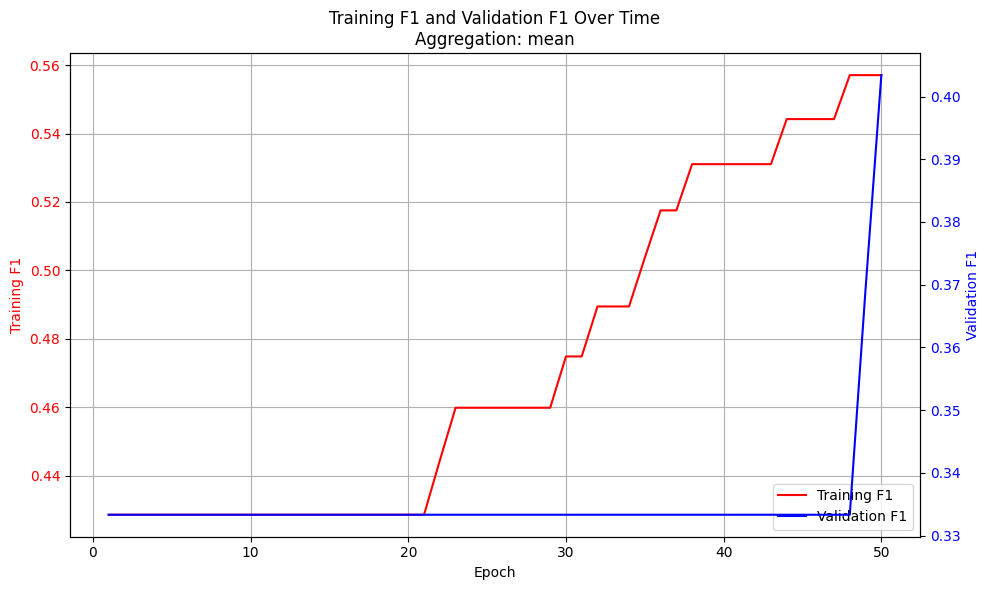

Final Train F1: 0.7556
Final Val F1: 0.6557


<Figure size 1000x600 with 0 Axes>

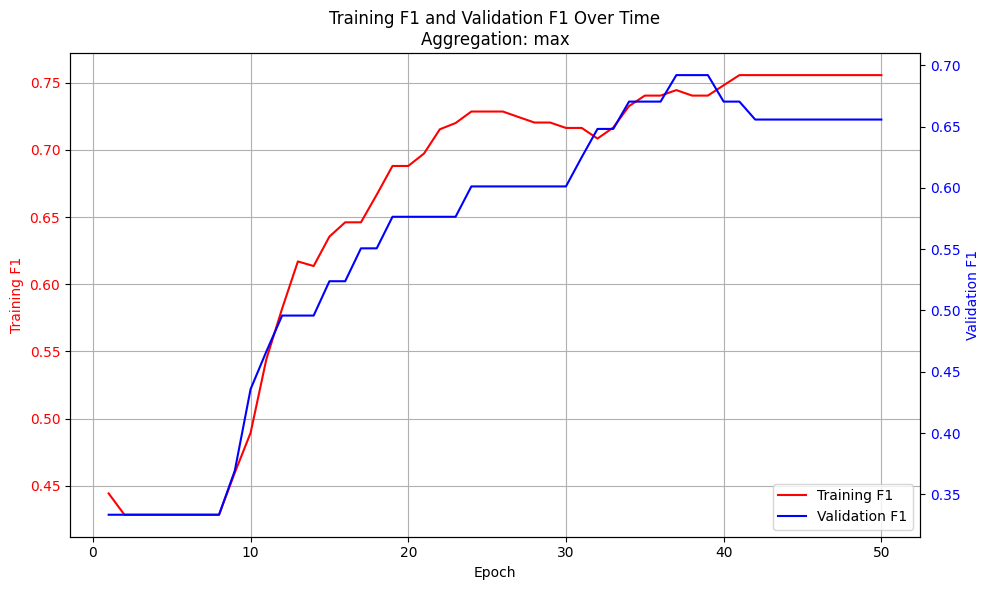

In [507]:
# Plotting F1 scores
# Load data
train_data = read_json_data(TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
eval_data = read_json_data(EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

criterion = nn.BCELoss()

# Initialising the model
input_dim = 10
hidden_dim = 16

# Visualising
for agg_method in ["sum", "mean", "max"]:
    # training model
    num_epochs = 50
    model = MyGraphNeuralNetwork(input_dim, hidden_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    train_losses, train_acc, eval_acc, train_f1s, val_f1s = train_model(
        model, optimizer, criterion,
        train_dataset=train_data,
        validation_dataset=eval_data,
        epochs=num_epochs,
        graph_aggregation_method=agg_method,
        verbose=False
    )

    print(f"Final Train F1: {train_f1s[-1]:.4f}")
    print(f"Final Val F1: {val_f1s[-1]:.4f}")

    plot_training_and_validation(train_f1s, val_f1s, aggregation=agg_method, metric="F1")

## Q1.2 - Analyzing the Dataset

You may notice that the model performs worse on the evaluation dataset. The goal of this task
is to analyze the dataset and identify potential issues that might affect the model’s performance.


In [508]:
# Helper function to visualise graphs:
def visualize_graph(G):
    
    # creating layout to visualise the graph
    pos = nx.spring_layout(G)

    # draw the graph
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_size=500, font_size=8, font_color="white", edge_color="gray")
    plt.title("Homogenous Graph Visualization")
    plt.show()

def visualise_graph_features(features_0, features_1, suffix=""):
    """plot clusters and their distribution"""
    plt.figure(figsize=(12, 8))
    
    # Convert to numpy arrays and get the first feature dimension
    features_0_np_1 = np.array(features_0)[:, 0]  # Take first feature dimension
    features_0_np_2 = np.array(features_0)[:, 1]  # Take second feature dimension
    
    features_1_np_1 = np.array(features_1)[:, 0]  # Take first feature dimension
    features_1_np_2 = np.array(features_1)[:, 1]  # Take first feature dimension
   
    plt.scatter(features_0_np_1, features_0_np_2, alpha=0.6, label='Class 0', color='red')
    plt.scatter(features_1_np_1, features_1_np_2, alpha=0.6, label='Class 1', color='blue')

    plt.xlabel('First Feature Dimension')
    plt.ylabel('Class') 
    plt.title(f'Feature Distribution by Class: {suffix}')
    plt.yticks([0, 1], ['Class 0', 'Class 1'])
    plt.legend()
    plt.show()

### Q1.2.a - Plotting
• Plot the topologies of the graphs.

• Plot the feature distributions.

• Plot the label distributions.

In [509]:
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  
def plot_class_distribution(labels, title="Training"):
   
    # count frequency of each label
    classes = np.unique(labels)
    zero_count, one_count = 0, 0
    for label in labels:
        if label == 0:
            zero_count += 1
        else:
            one_count += 1
            
    counts = [zero_count, one_count]

    # create bar plot
    plt.figure(figsize=(6, 4))
    bars = plt.bar(classes, counts, color='skyblue')
    plt.xlabel("Class Label")
    plt.ylabel("Frequency")
    plt.title(f"Class Distribution: {title}")
    plt.xticks(classes)

    for bar in bars:
        # put label on the corresponding bar (height used for positioning label)
        height = bar.get_height()
        plt.annotate(f'{int(height)}',
                     xy=(bar.get_x() + bar.get_width() / 2, height / 2),
                     ha='center', va='center', color='black', fontsize=12)
    
    plt.show()


def plot_graph_topology(A, suffix="", node_color="skyblue"):
    # convert adjacency matrix to numpy array if needed
    if not isinstance(A, np.ndarray):
        A = A.numpy()

    # setting up the graph
    G = nx.from_numpy_array(A)

    # visualising the graph
    plt.figure(figsize=(6, 6))
    pos = nx.spring_layout(G, seed=42)  
    nx.draw(G, pos, with_labels=True, edge_color='black', node_color=node_color, node_size=500)
    plt.title(f"Graph Topology: {suffix}")
    plt.show()

# ####################################################
# END OF MODIFICATION
# #################################################### 

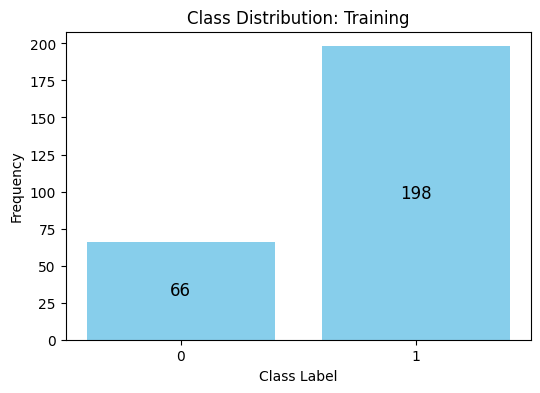

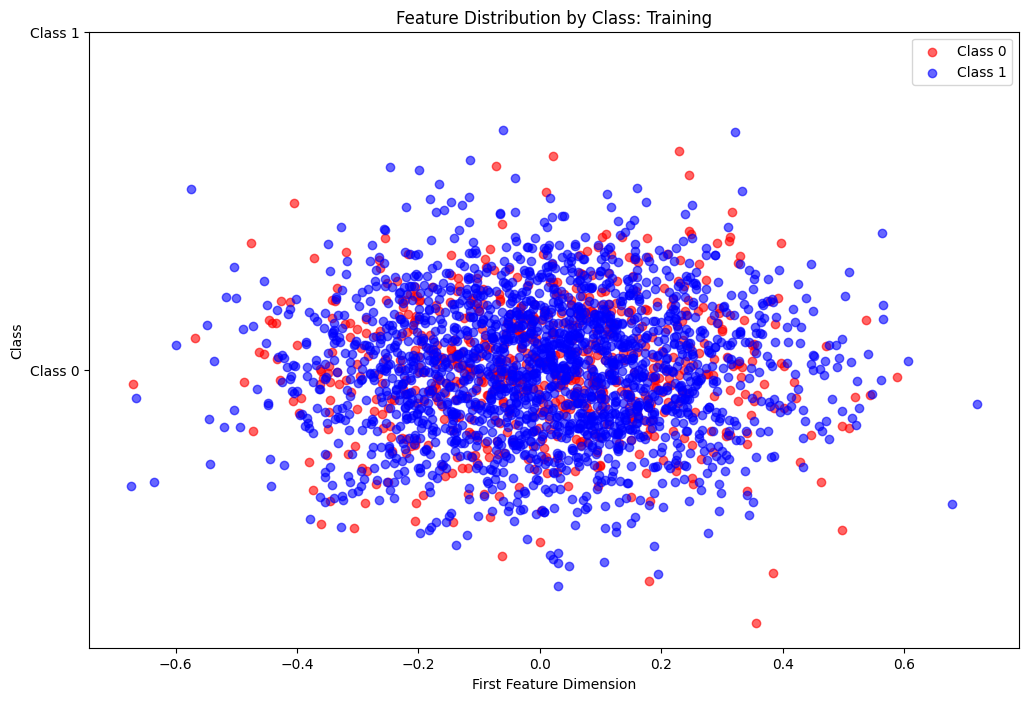

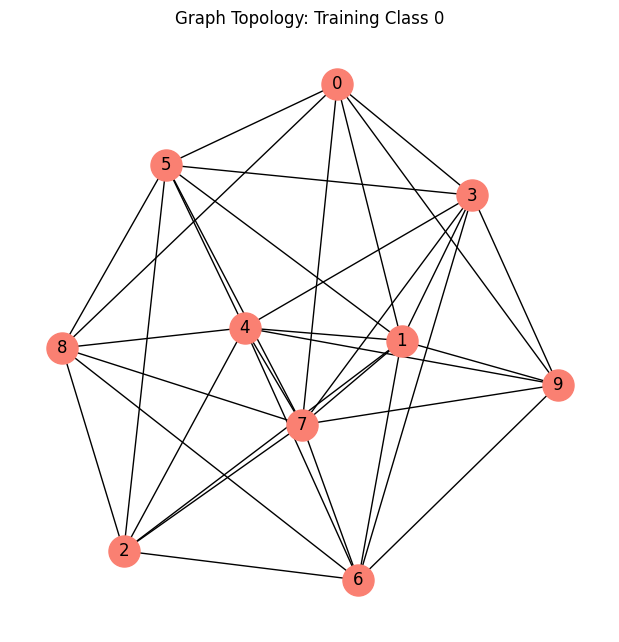

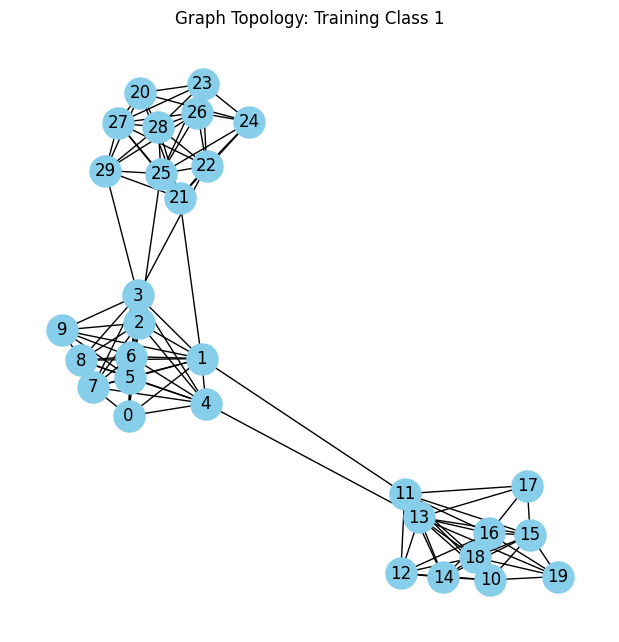

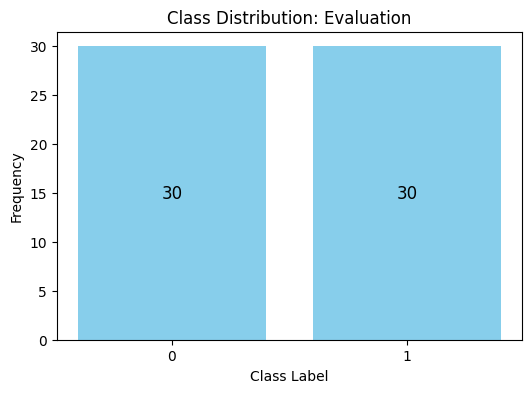

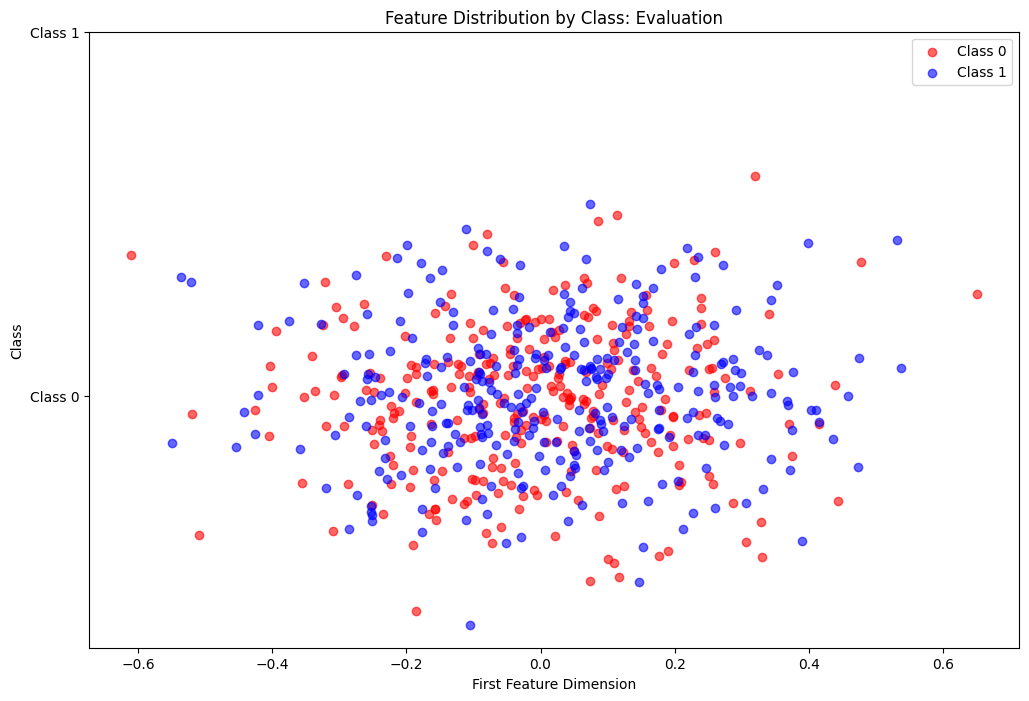

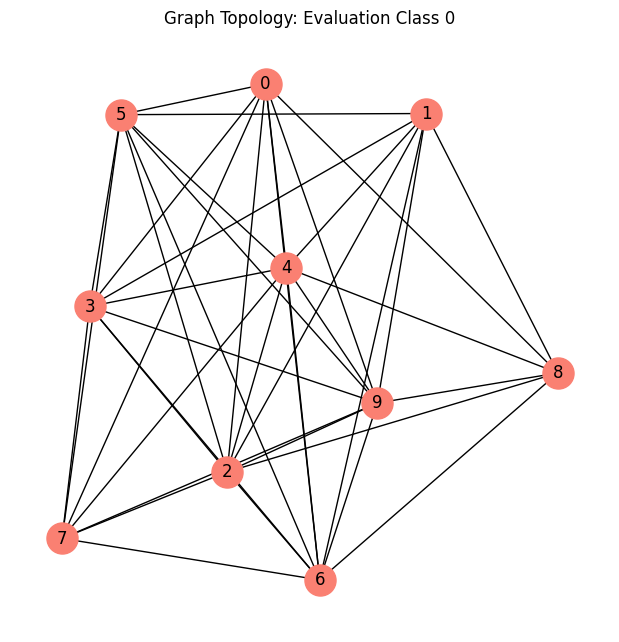

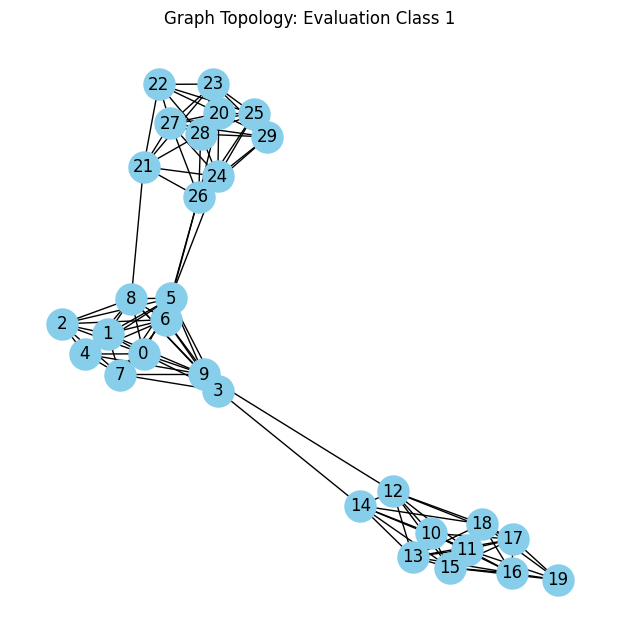

In [510]:
# Run the above scripts for train and eval. What do you observe?
def find_X_A_for_label(list_of_data,label=1):
    """Label"""
    for X,A,y in list_of_data:
        if y==label:
            return X,A

# Load data
train_data = read_json_data(TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
eval_data = read_json_data(EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# Getting Labels
train_labels = [int(y) for _,_,y in train_data]
eval_labels = [int(y) for _,_,y in eval_data]

# Getting Features
train_features_0 = [X.numpy() for X, _, y in train_data if y == 0]
train_features_1 = [X.numpy() for X, _, y in train_data if y == 1]

eval_features_0 = [X.numpy() for X, _, y in eval_data if y == 0]
eval_features_1 = [X.numpy() for X, _, y in eval_data if y == 1]

# Find a graph for each of the classes
X0_train, A0_train = find_X_A_for_label(train_data, 0)
X1_train, A1_train = find_X_A_for_label(train_data, 1)

X0_eval,A0_eval = find_X_A_for_label(eval_data, 0)
X1_eval, A1_eval = find_X_A_for_label(eval_data, 1)

# Plotting Train
plot_class_distribution(train_labels, "Training")
visualise_graph_features(train_features_0, train_features_1, "Training")
plot_graph_topology(A0_train, "Training Class 0", "salmon")
plot_graph_topology(A1_train, "Training Class 1", "skyblue")

# Plotting Eval
plot_class_distribution(eval_labels, "Evaluation")
visualise_graph_features(eval_features_0, eval_features_1, "Evaluation")
plot_graph_topology(A0_eval, "Evaluation Class 0", "salmon")
plot_graph_topology(A1_eval, "Evaluation Class 1", "skyblue")


## Question 1.3 - Overcoming Dataset Challenges

In this section, you will attempt to address the challenges identified by improving the model or training process.

### Q1.3.a - Adapting the GCN

Modify your GCN implementation from Q1.1 to accept the number of layers and output dimen-
sion (i.e. the graph embedding dimension) as parametes. Experiment with different hyperparam-
eters, such as:

• Number of layers.

• Hidden dimension size.

You will implement:

• Implement GCN as described above.

• Experiment with hyperparameters and report the results and plots.

Hint: The ModuleList class might be useful.

In [511]:
import torch
import torch.nn as nn

# Layer for the improved GCN
class MyGCNLayer2(nn.Module):
    def __init__(self, input_dim, output_dim, use_nonlinearity=True):
        super(MyGCNLayer2, self).__init__()
        self.use_nonlinearity = use_nonlinearity
        self.Omega = nn.Parameter(torch.randn(input_dim, output_dim) * torch.sqrt(torch.tensor(2.0) / (input_dim + output_dim)))
        self.beta = nn.Parameter(torch.zeros(output_dim))

    def forward(self, H_k, A_normalized):
        agg = torch.matmul(A_normalized, H_k) # local aggregation
        H_k_next = torch.matmul(agg, self.Omega) + self.beta
        return F.relu(H_k_next) if self.use_nonlinearity else H_k_next

class MyGraphNeuralNetwork2(nn.Module):
    
    # initialise the model
    def __init__(self, input_dim, hidden_dim, num_layers=1, output_dim=1):
        super(MyGraphNeuralNetwork2, self).__init__()
        self.num_hidden_layers = num_layers
        self.output_dim = output_dim
        self.layers = nn.ModuleList()

        # hidden layer 1: maps input to hidden representation (always at least 1 hidden layer in this implementation)
        self.layers.append(MyGCNLayer2(input_dim, hidden_dim, True))

        # additional hidden layers
        for _ in range(num_layers - 1):
            self.layers.append(MyGCNLayer2(hidden_dim, hidden_dim, True))

        # output layer maps hidden representation to output of size output_dim
        self.layers.append(MyGCNLayer2(hidden_dim, output_dim, False))

    def forward(self, A, X, graph_aggregation_method='mean', **kwargs):

        # add self-loops and compute symmetric normalization of A
        A_tilde = A + torch.eye(A.shape[0])
        A_norm = symmetric_normalize(A_tilde)

        embeddings = []
        out = X
        for layer in self.layers:
            out = layer(out, A_norm)
            embeddings.append(out)

        # aggregation on the final layer's output
        if graph_aggregation_method == "sum":
            graph_embedding = torch.sum(out, dim=0)
        elif graph_aggregation_method == "mean":
            graph_embedding = torch.mean(out, dim=0)
        elif graph_aggregation_method == "max":
            graph_embedding, _ = torch.max(out, dim=0)

        # apply the activation function based on the output dimension, supporting 1 or 2 for now, could extend to more classes.
        if self.output_dim == 1:
            graph_output = torch.sigmoid(graph_embedding)
        elif self.output_dim == 2:
            class_probs = torch.softmax(graph_embedding, dim=0)
            return class_probs

        # making sure output is at least 1D
        if graph_output.dim() == 0:
            graph_output = graph_output.unsqueeze(0)

        # handle NaN values
        if torch.isnan(graph_output).any():
            graph_output = torch.where(torch.isnan(graph_output), torch.zeros_like(graph_output), graph_output)

        if kwargs.get("return_embeddings", None):
            return graph_output, embeddings
        else:
            return graph_output


Final Train Accuracy: 1.0000
Final Val Accuracy: 1.0000
Final Train F1: 1.0000
Final Val F1: 1.0000


<Figure size 1000x600 with 0 Axes>

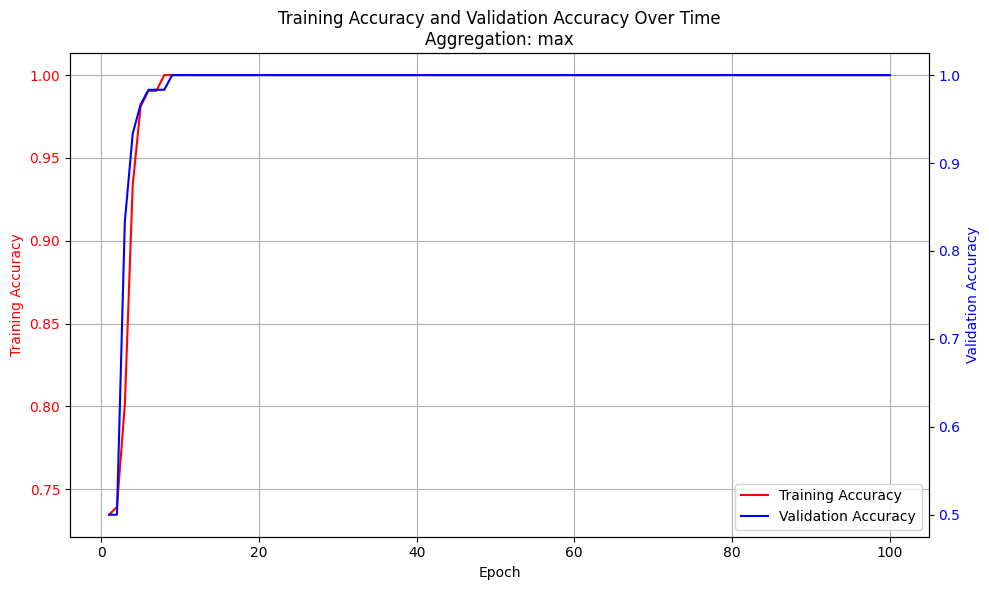

In [512]:
from torch.utils.data import random_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# setting up PCA on training data
def fit_pca_on_training_data(train_data, n_components):
    all_features = []
    for X, A, y in train_data:
        all_features.append(X)
    all_features = np.vstack(all_features)  

    pca = PCA(n_components=n_components)
    pca.fit(all_features)
    return pca

# applying PCA to the dataset
def apply_pca_to_dataset(dataset, pca):
    new_dataset = []
    for X, A, y in dataset:
        # transform node features using PCA and convert to tensor
        new_X = pca.transform(X)
        new_X = torch.tensor(new_X, dtype=torch.float)

        # convert adjacency matrix to tensor if required
        if not torch.is_tensor(A):
            A_tensor = torch.tensor(A, dtype=torch.float)
        else:
            A_tensor = A.clone().detach()

        new_dataset.append((new_X, A_tensor, y))
    return new_dataset

# standardizing features with mean 0 and variance 1
def standardize_features(data):
    scaler = StandardScaler()
    new_data = []
    for X, A, y in data:
        # standardize the node features
        X_std = scaler.fit_transform(X)
        X_tensor = torch.tensor(X_std, dtype=torch.float)

        # convert the adjacency matrix to a tensor if needed
        if not torch.is_tensor(A):
            A_tensor = torch.tensor(A, dtype=torch.float)
        else:
            A_tensor = A.clone().detach()

        new_data.append((X_tensor, A_tensor, y))
    return new_data

# splitting the training data into training and validation subsets
def split_training_data(train_data, train_ratio=0.8, seed=42):
    dataset_size = len(train_data)
    train_size = int(train_ratio * dataset_size)
    val_size = dataset_size - train_size

    # set the seed for reproducibility
    if seed is not None:
        torch.manual_seed(seed)

    train_subset, val_subset = random_split(train_data, [train_size, val_size])
    return train_subset, val_subset

# Load data
train_data = read_json_data(TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
eval_data = read_json_data(EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# Applying PCA to data
n_components = 9 # Desired number of principal components, set to 10 for default
pca = fit_pca_on_training_data(train_data, n_components)

# Standardize both training and evaluation datasets
train_data = standardize_features(train_data)
eval_data = standardize_features(eval_data)

# Apply PCA to the datasets
train_data = apply_pca_to_dataset(train_data, pca)
eval_data = apply_pca_to_dataset(eval_data, pca)

# Initialising the model
input_dim = n_components
hidden_dim = 16
layers = 3
output_dim = 2
model = MyGraphNeuralNetwork2(input_dim, hidden_dim, output_dim=output_dim, num_layers = layers)

# Loss function and optimizer
if output_dim == 1:
    criterion = nn.BCELoss() # binary classification with output_dim = 1
else:
    criterion = nn.CrossEntropyLoss() # multi-class classification with output_dim > 1
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Splitting the Data
train_data, val_data = split_training_data(train_data,0.8)

# training the model
num_epochs = 100
train_losses, train_acc, eval_acc, train_f1s, val_f1s = train_model(
    model, 
    optimizer, 
    criterion, 
    train_data, 
    eval_data, 
    epochs=num_epochs, 
    graph_aggregation_method="max",
    verbose=False
)
print(f"Final Train Accuracy: {train_acc[-1]:.4f}")
print(f"Final Val Accuracy: {eval_acc[-1]:.4f}")
print(f"Final Train F1: {train_f1s[-1]:.4f}")
print(f"Final Val F1: {val_f1s[-1]:.4f}")

# Visualising
plot_training_and_validation(train_acc, eval_acc, "max")

### Q1.3.b - Improving the Model
Identify and implement three different methods to overcome the challenges discovered in
Q1.2. Your goal is to achieve the highest possible score. You may experiment with:

• Model architecture modifications.

• Data preprocessing techniques.

• Hyperparameter tuning.

• Loss function adjustments.

<Figure size 1000x600 with 0 Axes>

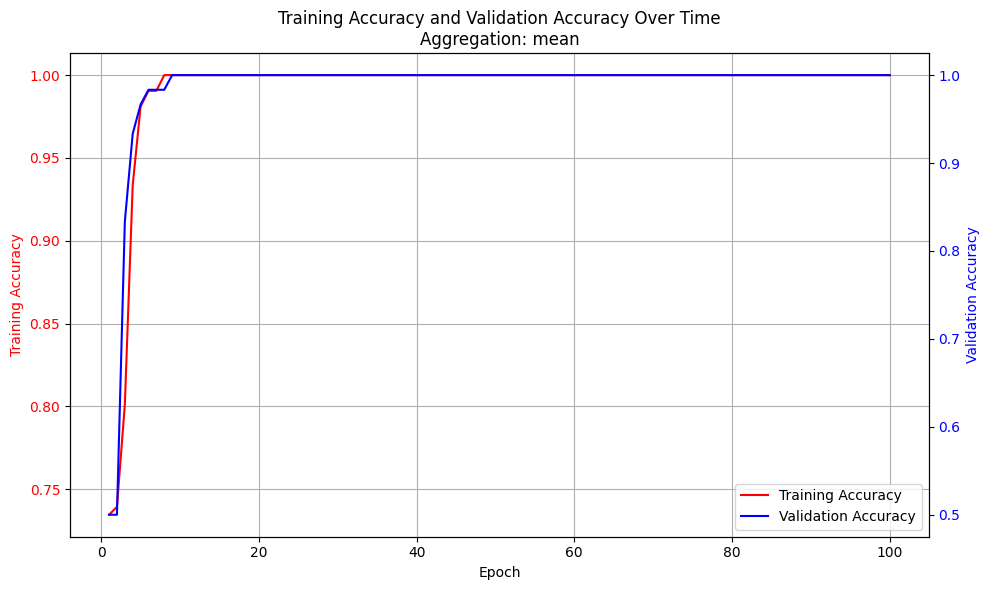

In [513]:
# SOLUTION Q1.3.b

# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################


# Call this function in the end.
plot_training_and_validation(train_acc, eval_acc, aggregation="max")


# ####################################################
# END OF MODIFICATION
# ####################################################

### Q1.3.c - Evaluating the Best Model

Plot the performance of your best model over 100 epochs or more, averaged over multiple
random (i.i.d.) runs (at least 10 runs) to produce a smoothed training and evaluation accuracy
curve. 

Note: Your score will be based on the smoothed curve.

Hints:

• Set verbose=False in the train model function to suppress excessive logging.

• Use np.mean with an axis parameter to compute the average performance over multiple
runs.


<Figure size 1000x600 with 0 Axes>

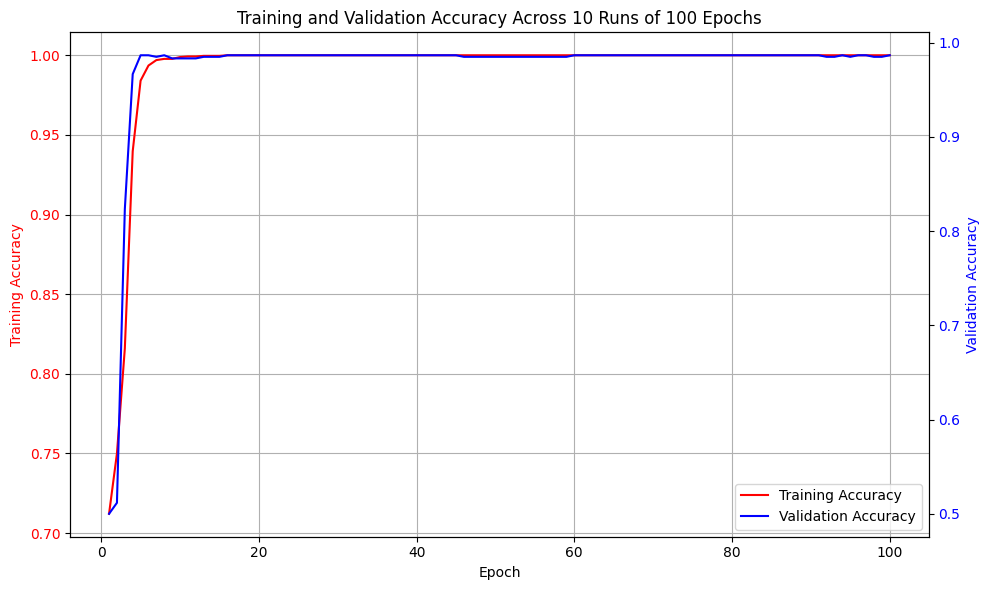

Final Averaged Training Accuracy: 1.00
Final Averaged Validation Accuracy: 0.99


<Figure size 1000x600 with 0 Axes>

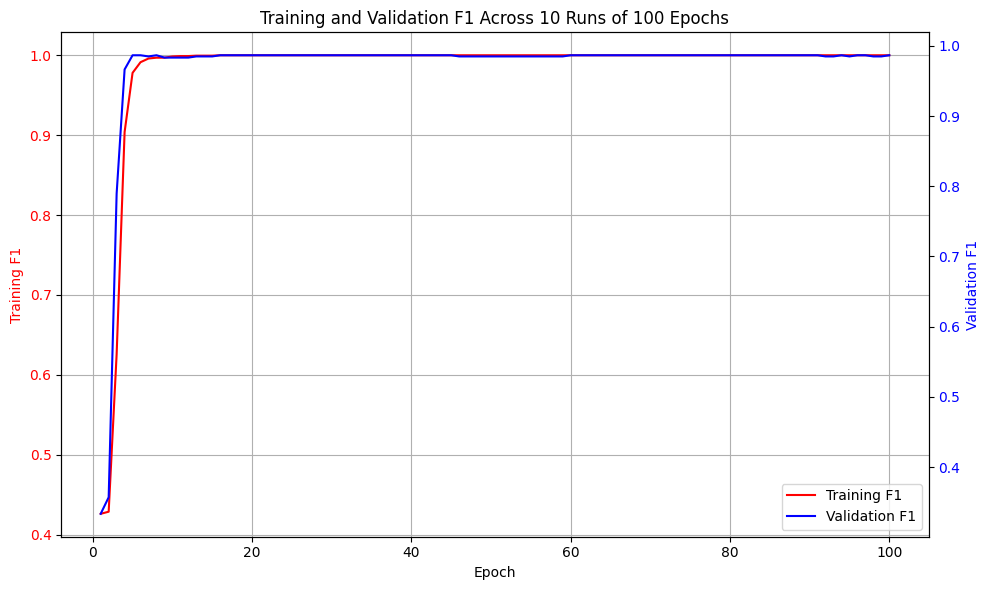

Final Averaged Training F1: 1.00
Final Averaged Validation F1: 0.99


In [514]:
# SOLUTION Q1.3.c - Smooth Curve

# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################
num_runs = 10
num_epochs = 100

# store accuracy curves for each run
all_train_acc = []
all_eval_acc = []
all_train_f1 = []
all_eval_f1 = []

# Load data
train_data = read_json_data(TRAIN_DATA_PATH, has_label=True)
eval_data = read_json_data(EVAL_DATA_PATH, has_label=True)

# Applying PCA to data
n_components = 9 # Desired number of principal components, set to 10 for no PCA
pca = fit_pca_on_training_data(train_data, n_components)

# Transform both training and evaluation datasets
train_data = standardize_features(train_data)
eval_data = standardize_features(eval_data)

train_data = apply_pca_to_dataset(train_data, pca)
eval_data = apply_pca_to_dataset(eval_data, pca)

# Initialising the model
input_dim = n_components
hidden_dim = 16
layers = 3
output_dim = 2

for run in range(num_runs):
    # Set a seed for each run for reproducibility
    seed = 42 + run
    torch.manual_seed(seed)
    np.random.seed(seed)

    model = MyGraphNeuralNetwork2(input_dim, hidden_dim, output_dim=output_dim, num_layers = layers)

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # define the loss function based on the output dimension
    if output_dim == 1:
        criterion = nn.BCELoss()
    else:
        criterion = nn.CrossEntropyLoss()

    train_losses, train_acc, eval_acc, train_f1s, eval_f1s = train_model(
        model,
        optimizer,
        criterion,
        train_data,
        eval_data,
        epochs=num_epochs,
        graph_aggregation_method="max",
        verbose=False
    )

    # append the accuracy and F1 curves from this run.
    all_train_acc.append(train_acc)
    all_eval_acc.append(eval_acc)
    all_train_f1.append(train_f1s)
    all_eval_f1.append(eval_f1s)

all_train_acc = np.array(all_train_acc)
all_eval_acc = np.array(all_eval_acc)

# Average across runs 
avg_train_acc = np.mean(all_train_acc, axis=0)
avg_eval_acc = np.mean(all_eval_acc, axis=0)

# Plot the smoothed training and evaluation accuracy curves
plot_training_and_validation(avg_train_acc, avg_eval_acc, aggregation="max",
                             title="Training and Validation Accuracy Across 10 Runs of 100 Epochs",
                             metric="Accuracy")
print("Final Averaged Training Accuracy: {:.2f}".format(avg_train_acc[-1]))
print("Final Averaged Validation Accuracy: {:.2f}".format(avg_eval_acc[-1]))

all_train_f1 = np.array(all_train_f1)
all_eval_f1 = np.array(all_eval_f1)

# Average across runs 
avg_train_f1 = np.mean(all_train_f1, axis=0)
avg_eval_f1 = np.mean(all_eval_f1, axis=0)

plot_training_and_validation(avg_train_f1, avg_eval_f1, aggregation="max",
                             title="Training and Validation F1 Across 10 Runs of 100 Epochs",
                             metric="F1")
print("Final Averaged Training F1: {:.2f}".format(avg_train_f1[-1]))
print("Final Averaged Validation F1: {:.2f}".format(avg_eval_f1[-1]))
# 
# # Call this function in the end (with the averaged values)
# plot_training_and_validation(averaged_train_acc, averaged_eval_acc)

# ####################################################
# END OF MODIFICATION
# ####################################################